<a href="https://colab.research.google.com/github/karthikmohan1702/EVA6/blob/main/Session_4/Architectural_basics/S4_MNIST_99_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
%matplotlib inline

## Model structure

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)# IP=28x28, OP=26x26, RF=3x3 
        self.conv2 = nn.Conv2d(16, 16, 3)# IP=26x26, OP=24x24, RF=5x5 
        self.batchnorm2d_1 = nn.BatchNorm2d(16)
        self.dropout_1 = nn.Dropout(0.069)

        self.conv3 = nn.Conv2d(16, 16, 3)# IP=24x24, OP=22x22, RF=7x7 
        self.batchnorm2d_2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)# IP=22x22, OP=11x11, RF=14x14 
        self.dropout_2 = nn.Dropout(0.069)

        self.conv5 = nn.Conv2d(16, 16, 3)# IP=11x11, OP=9x9, RF=16x16 
        self.batchnorm2d_4 = nn.BatchNorm2d(16)
        

        self.conv7 = nn.Conv2d(16, 16, 3)# IP=9x9, OP=7x7, RF=18x18 
        self.conv8 = nn.Conv2d(16, 16, 3)# IP=7x7, OP=5x5, RF=20x20 
        self.pool2 = nn.AvgPool2d(5)
        self.conv9 = nn.Conv2d(16, 10, 1)
        # self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.dropout_1(self.batchnorm2d_1(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.dropout_2(self.pool1(self.batchnorm2d_2(F.relu(self.conv3(x)))))
  
        x = self.batchnorm2d_4(F.relu(self.conv5(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool2(x)        
        x = self.conv9(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        
        return F.log_softmax(x,dim=1)

## Summary of the architecture

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

print("device ==> ", device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 16, 24, 24]           2,320
       BatchNorm2d-3           [-1, 16, 24, 24]              32
           Dropout-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,320
       BatchNorm2d-6           [-1, 16, 22, 22]              32
         MaxPool2d-7           [-1, 16, 11, 11]               0
           Dropout-8           [-1, 16, 11, 11]               0
            Conv2d-9             [-1, 16, 9, 9]           2,320
      BatchNorm2d-10             [-1, 16, 9, 9]              32
           Conv2d-11             [-1, 16, 7, 7]           2,320
           Conv2d-12             [-1, 16, 5, 5]           2,320
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Conv2d-14             [-1, 1

In [4]:
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_1): Dropout(p=0.069, inplace=False)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_2): Dropout(p=0.069, inplace=False)
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (conv9): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1))
)

## Loading Train & test Dataset

In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Train Loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# Test loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

torch.Size([1, 28, 28])
6


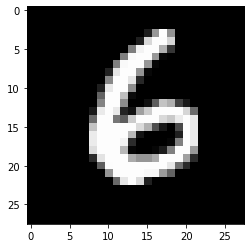

In [6]:
imgs, lbls = next(iter(train_loader))
print(imgs[15].data.shape)
classes = range(10)
print(classes[lbls[0]])

plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

## Defining Train & Test

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    
    return train_loss, train_accuracy 


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return train_loss, test_accuracy

## Training the Model

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.01)

train_loss_val = []
train_acc_val = []
test_loss_val = []
test_acc_val = []

for epoch in range(1, 20):
    print("Epoch ===> ", epoch)
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_val.append(train_acc)
    train_loss_val.append(train_loss)

    test_acc_val.append(test_acc)
    test_loss_val.append(test_loss)
    
    scheduler.step()
    

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch ===>  1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9801/10000 (98.01%)

Epoch ===>  2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9845/10000 (98.45%)

Epoch ===>  3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9818/10000 (98.18%)

Epoch ===>  4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

Epoch ===>  5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

Epoch ===>  6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

Epoch ===>  7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9920/10000 (99.20%)

Epoch ===>  8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9916/10000 (99.16%)

Epoch ===>  9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

Epoch ===>  10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9918/10000 (99.18%)

Epoch ===>  11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

Epoch ===>  12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

Epoch ===>  13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

Epoch ===>  14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

Epoch ===>  15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

Epoch ===>  16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

Epoch ===>  17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9946/10000 (99.46%)

Epoch ===>  18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Epoch ===>  19


loss=0.025792451575398445 batch_id=468: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]



Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)



## Plotting loss & accuracy of train & test

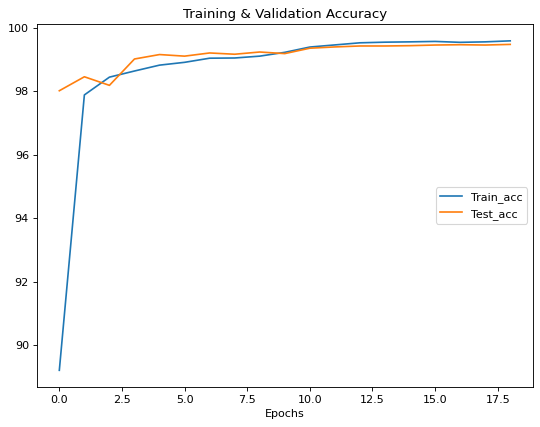

In [9]:
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
# "Training & Validation Accuracy"
plt.plot(train_acc_val, label = "Train_acc")
plt.plot(test_acc_val, label = "Test_acc")
plt.xlabel("Epochs")
plt.legend(loc="center right")
plt.title("Training & Validation Accuracy")
plt.show()